# C1 - Introduction to Human and Computer Vision
## Week 2 - Draft Notebook

In [48]:
import os
import re
import matplotlib.pyplot as plt

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week2')
os.chdir(BASE_PATH)
BASE_PATH

'c:\\Users\\Usuario\\Documents\\Màster\\C1\\Team5\\week2'

### Load datasets

In [27]:
from week2.src.image_dataset import ImageDataset, ColorSpace

DATA_DIRECTORY = '../data'

# Load the Cropped Dataset (QueryDataset) and Background Dataset (BGDataset)
QueryDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd1_w1', colorspace=ColorSpace.CieLab, interval=10)
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w2', colorspace=ColorSpace.CieLab, interval=10)

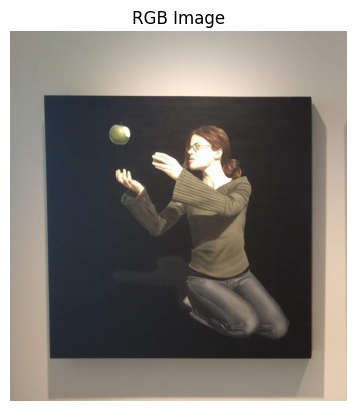

In [35]:
BGDataset.images[1].show_original()

### Task 1

### Task 2

### Task 3 - Background removal
- First approach:
    1. Convert image to gray color space.
    2. Use Canny edge detector.
    3. Apply morphological closing with a rectangle as structural element.
    4. Find painting contours.
    5. Fill the mask.

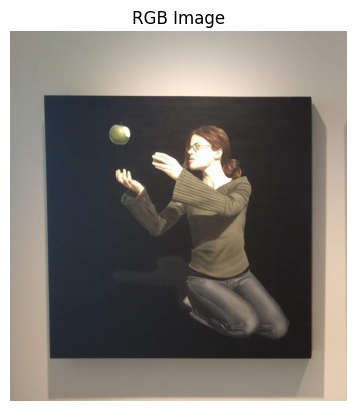

In [63]:
from src.background_removal import get_mask

get_mask(BGDataset.images[1].show_original())

### Task 4 - Background removal evaluation

### Task 5

### Task 6 - .pkl results generation